In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import imagehash
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from torch_optimizer.radam import RAdam

from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomRotate90, RGBShift, ChannelShuffle)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

# Configuration

In [3]:
CFG = {
    "make_dataset": True,
    "num_of_use"  : 22000,
    "thrs_sim"    : 0.75,
    "seed"        : 42,
    'device'      : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_img"   : '../input/petfinder-pawpularity-score/train/',
    "input_path"  : '../input/petfinder-pawpularity-score/train.csv',
    "input_eimg"  : '../input/petfinder-adoption-prediction/train_images/',
    "input_epath" : '../input/petfinder-adoption-prediction/train/train.csv',
    "output_path" : './',
    "model"       : "tf_efficientnetv2_s_in21k",
    "size"        : 512,
    "batch_size"  : 32,
    "epochs"      : 10,
    'T_0'         : 20,
    "lr"          : 0.001,
    'momentum'    : 0.9,
    'weight_decay': 1e-4,
    "accum_iter"  : 2,
    'early_stopping': 10,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'make_dataset': True,
 'num_of_use': 22000,
 'thrs_sim': 0.75,
 'seed': 42,
 'device': 'cpu',
 'input_img': '../input/petfinder-pawpularity-score/train/',
 'input_path': '../input/petfinder-pawpularity-score/train.csv',
 'input_eimg': '../input/petfinder-adoption-prediction/train_images/',
 'input_epath': '../input/petfinder-adoption-prediction/train/train.csv',
 'output_path': './',
 'model': 'tf_efficientnetv2_s_in21k',
 'size': 512,
 'batch_size': 32,
 'epochs': 10,
 'T_0': 20,
 'lr': 0.001,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'accum_iter': 2,
 'early_stopping': 10,
 'verbose_step': 1,
 'num_workers': 4}

In [4]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

# Calculate the similarity with imagehash 

In [5]:
df_train = pd.read_csv(CFG['input_path'])
df_train = df_train[(df_train.Pawpularity <= 20)|(50 <= df_train.Pawpularity)].reset_index(drop=True)
df_train["path"] = [f"{CFG['input_img']}{i}.jpg" for i in df_train.Id]

print(df_train.shape)
df_train.head()

(3536, 15)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
2,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...
3,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74,../input/petfinder-pawpularity-score/train/001...
4,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53,../input/petfinder-pawpularity-score/train/004...


In [6]:
%%time
if CFG["make_dataset"]:
    funcs = [imagehash.average_hash,
             imagehash.phash,
             imagehash.dhash,
             imagehash.whash]
    def run_hash(path):
        image = Image.open(path)
        return list(np.array([f(image).hash for f in funcs]).reshape(256))

    # Extract some samples from external data for accerarating.
    ext_paths = glob(CFG["input_eimg"]+'*')
    random.shuffle(ext_paths)
    paths = list(df_train.path) + ext_paths[:CFG['num_of_use']]
    print(len(paths))

    with ThreadPoolExecutor(CFG["num_workers"]) as e:
        hashes = e.map(run_hash, paths)
    hashes = [r for r in hashes]

25536
CPU times: user 13min 32s, sys: 36.7 s, total: 14min 9s
Wall time: 5min 53s


In [7]:
%%time
if CFG["make_dataset"]:
    hashes_all = torch.Tensor(np.array(hashes).astype(int)).to(CFG["device"])
    sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

    print(sims.shape)

(25536, 25536)
CPU times: user 9min 16s, sys: 11min 24s, total: 20min 41s
Wall time: 10min 50s


In [8]:
if CFG["make_dataset"]:
    last = len(df_train.path)

    res  = []
    for e_idx in range(last, last+CFG["num_of_use"]):
        vec = sims[e_idx][:last]
        sim_idxs = np.where(vec > CFG["thrs_sim"])[0]
        if len(sim_idxs) == 0 or max(vec) == 1:
            continue
        ids = [os.path.basename(paths[i])[:-4] for i in sim_idxs]
        score = df_train[df_train.Id.isin(ids)].Pawpularity.mean()
        res.append([paths[e_idx], score, len(sim_idxs), max(vec)])

    df_external_train = pd.DataFrame(res, columns=["path", "Pawpularity", "num", "max_sim"])
else:
    df_external_train = pd.read_csv("../input/petfinder-cnn-models-with-external-data/external_train.csv")

df_external_train.to_csv("./external_train.csv", index=False)

In [9]:
print(df_external_train.shape)
df_external_train.head()

(5102, 4)


,path,Pawpularity,num,max_sim
0,../input/petfinder-adoption-prediction/train_i...,50.00,1,0.765625
1,../input/petfinder-adoption-prediction/train_i...,15.00,1,0.773438
2,../input/petfinder-adoption-prediction/train_i...,16.50,2,0.757812
3,../input/petfinder-adoption-prediction/train_i...,60.25,4,0.796875
4,../input/petfinder-adoption-prediction/train_i...,92.00,1,0.757812


<AxesSubplot:>

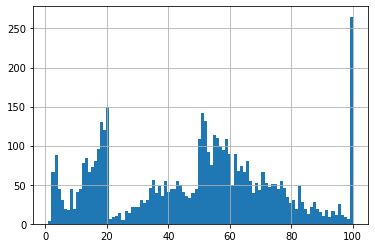

In [10]:
df_external_train.Pawpularity.hist(bins=100)

# Load data and run pre-processing

In [11]:
df_train = pd.read_csv(CFG['input_path'])
df_train["path"] = [f"{CFG['input_img']}{i}.jpg" for i in df_train.Id]

print(df_train.shape)
df_train.head(2)

(9912, 15)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...


In [12]:
df_train = pd.concat([df_train, df_external_train]).reset_index(drop=True)
df_train = df_train[["path","Pawpularity"]]
df_train["Pawclass"] = df_train.Pawpularity / 100

In [13]:
df_train.describe()

,Pawpularity,Pawclass
count,15014.000000,15014.000000
mean,41.749347,0.417493
std,23.414051,0.234141
min,1.000000,0.010000
25%,25.000000,0.250000
50%,37.000000,0.370000
75%,56.000000,0.560000
max,100.000000,1.000000


<AxesSubplot:>

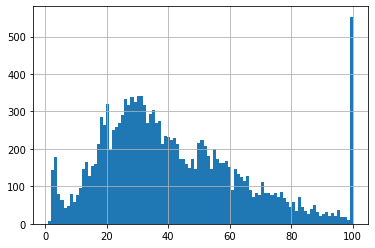

In [14]:
df_train.Pawpularity.hist(bins=100)

# Define model

In [15]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output
    
class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [16]:
class PetFinderDataset(Dataset):
    def __init__(self, df_img, df_meta, transforms=None, train=True, output_meta=True, output_label=True):
        super().__init__()
        self.df_img  = df_img.reset_index(drop=True).copy()
        self.df_meta = None if df_meta is None else df_meta.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.train        = train
        self.output_meta  = output_meta
        self.output_label = output_label
        
    def __len__(self):
        return self.df_img.shape[0]
    
    def __getitem__(self, index: int):
        img  = get_img(self.df_img.loc[index].path)
        y    = torch.from_numpy(np.array(self.df_img.loc[index].Pawclass))  # Pawpularity
        if self.output_meta:
            meta = torch.from_numpy(np.array(self.df_meta.loc[index], dtype=float))
        if self.transforms:
            if self.train:
                img = self.transforms(image=img)['image']
            else:
                h, w, _ = img.shape
                trans = self.transforms(h, w)
                img   = trans(image=img)['image']
        if self.output_label:
            if self.output_meta:
                return img, meta, y
            else:
                return img, y
        if self.output_meta:
            return img, meta
        return img

In [17]:
def get_train_transforms():
    return Compose([
        RandomResizedCrop(CFG['size'], CFG['size'], p=1.0),
        HorizontalFlip(p=0.5),
        MotionBlur(p=0.5),
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)
  
def get_valid_transforms(h, w):
    h = int(CFG["size"]*1.2) if int(CFG["size"]*1.2) < h else h
    w = int(CFG["size"]*1.2) if int(CFG["size"]*1.2) < w else w
    return Compose([
        CenterCrop(h, w, p=1.0),
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

def prepare_dataloader(train, train_meta, valid, valid_meta):
    train_ds = PetFinderDataset(train, train_meta, transforms=get_train_transforms(), output_meta=False)
    valid_ds = PetFinderDataset(valid, valid_meta, transforms=get_valid_transforms, train=False, output_meta=False)
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['batch_size'],
                                               drop_last=False,
                                               pin_memory=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    val_loader = torch.utils.data.DataLoader(valid_ds,
                                             batch_size=CFG['batch_size'],
                                             pin_memory=False,
                                             shuffle=False,
                                             num_workers=CFG['num_workers'])
    return train_loader, val_loader

In [18]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    mean_loss    = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, targets) in pbar:
        imgs    = imgs.to(device).float()
        targets = targets.reshape(-1,1).to(device).float()

        with autocast():
            img_preds = model(imgs)
            loss = loss_fn(img_preds, targets) / CFG['accum_iter']
        scaler.scale(loss).backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01
        mean_loss += loss.item()

        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() 
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    return mean_loss/len(train_loader)
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum   = 0
    sample_num = 0
    img_preds_all = []
    img_truth_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, targets) in pbar:
        imgs    = imgs.to(device)
        targets = targets.reshape(-1,1).to(device).float()
        
        img_preds = model(imgs)
        img_preds_all += [img_preds.detach().cpu().numpy()]
        img_truth_all += [targets.detach().cpu().numpy()]
        
        loss = loss_fn(img_preds, targets)
        loss_sum   += loss.item()*targets.shape[0]
        sample_num += targets.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
            
    img_preds_all = (sigmoid(np.concatenate(img_preds_all))*100).astype(int)
    img_truth_all = (np.concatenate(img_truth_all)*100).astype(int)
    #img_preds_all = np.concatenate(img_preds_all)
    #img_truth_all = np.concatenate(img_truth_all)
    rmse = np.sqrt(mean_squared_error(img_preds_all, img_truth_all))
    print('validation rmse = {:.6f}'.format(rmse))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
    return rmse, loss_sum/sample_num,  [img_preds_all, img_truth_all]

In [19]:
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       # Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

# Run training

In [20]:
train, valid = train_test_split(df_train, test_size=0.3, random_state=CFG["seed"])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

print(train.shape, valid.shape)

(10509, 3) (4505, 3)


In [21]:
if not CFG["make_dataset"]:
    train_loader, val_loader = prepare_dataloader(train, None, valid, None)

    not_improved_cnt = 0
    best_rmse  = 999
    best_epoch = 0
    histories  = {}

    device    = torch.device(CFG['device'])
    model     = Model(CFG["model"])
    model.to(device)
    scaler    = GradScaler()
    #optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
    #scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])
    optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    scheduler = None
    #loss      = RMSELoss().to(device)
    loss      = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(CFG['epochs']):
        train_loss = train_one_epoch(epoch, model, loss, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            rmse, valid_loss, hist = valid_one_epoch(epoch, model, loss, val_loader, device, scheduler=None, schd_loss_update=False)
        histories[epoch] = [train_loss, valid_loss, rmse, hist]

        if rmse < best_rmse:
            print('Best model will be saved to output path after completing this fold')
            best_model = copy.deepcopy(model)
            best_rmse  = rmse
            best_epoch = epoch
            not_improved_cnt = 0
        elif CFG['early_stopping'] == not_improved_cnt:
            print("Met early stopping.")
            break
        else:
            not_improved_cnt += 1

    torch.save(best_model.state_dict(), f"{CFG['output_path']}petfinder_swin_binary_external.pt")

    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()

In [22]:
if not CFG["make_dataset"]:
    # Plot last epoch result
    pred, gt = histories[best_epoch][3:][0]
    plt.scatter(x=pred, y=gt)
    plt.show()